## 3DCORE with THUX 


In [239]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import LightSource
from matplotlib import cm
import heliopy
import astropy
import datetime
from datetime import timedelta
import astropy.constants as const
from sunpy.time import parse_time
import heliopy.spice as spice
import heliopy.data.spice as spicedata
import seaborn as sns
import glob
from scipy.io import readsav
import os
import copy


#these are our own packages
import py3dcore
import heliosat

!pwd

/home/cmoestl/pycode/solar_orbiter


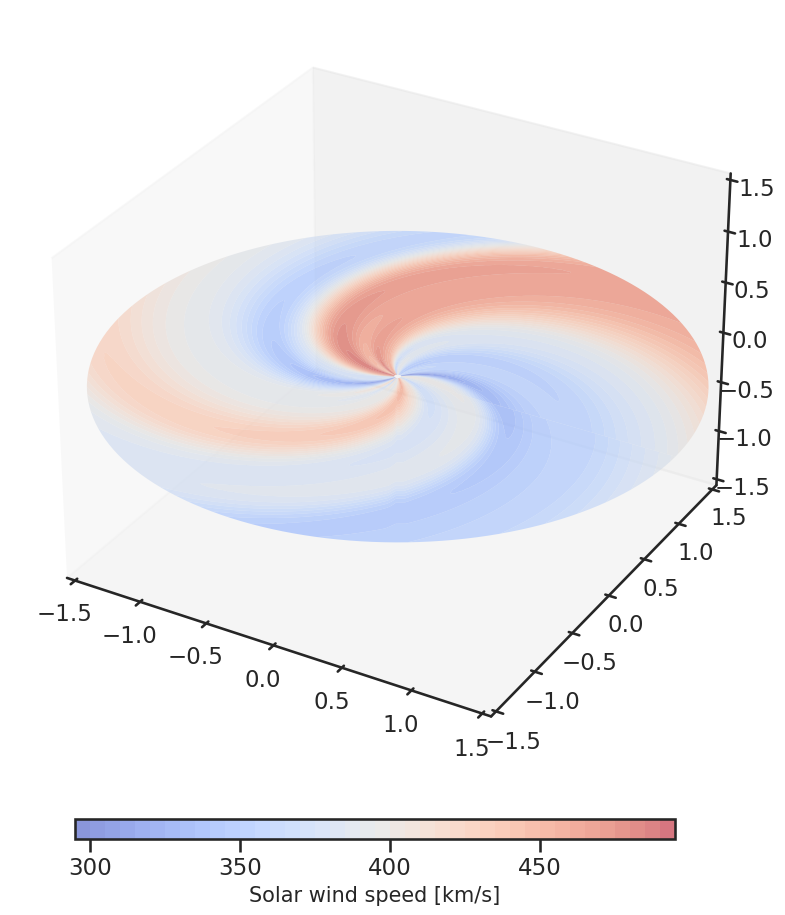

In [240]:
#load THUX example wind

wsa_thux=np.loadtxt('data/thux/wsa-vmap-19apr2020-v2.txt')
#wsa_apr_thux=np.loadtxt('data/thux/wsa-planets-missions-19apr2020.txt',skiprows=1)

#convert matlab time to matplotlib time

#wsa_apr_thux_datetime=[None]*len(wsa_apr_thux)
#for p in np.arange(len(wsa_apr_thux)):
#        wsa_apr_thux_datetime[p]= datetime.datetime.fromordinal(wsa_apr_thux[p,0].astype(int) ) + \
#        datetime.timedelta(days=wsa_apr_thux[p,0]%1) - datetime.timedelta(days = 366) 


#vEarth	vMercury	vVenus	vMars	vBepi	vPSP	vSOLO	vSTEREOA	vSTEREOB
#wsa_apr_thux_earth=wsa_apr_thux[:,1]
#wsa_apr_thux_solo=wsa_apr_thux[:,7]
#wsa_apr_thux_sta=wsa_apr_thux[:,8]


def plot_bgsw(ax,cbarax):

    
    #for rotation
    #k=0
    #CR 2229	2020 Mar 28	0853 start
    #k=14
    #rotSun = 27.2753
    #rotAngle = (2 * np.pi / rotSun) * k #+np.pi/2 
    #rotAngle = (2 * np.pi / rotSun) * k  

    thetaLen=180
    rLen=425
    r_sun = 695700.
    au = 149597870.
    startBGSW = 5

    #grid
    angle = np.deg2rad(np.arange(0, 362, 362 / thetaLen)) #+ np.deg2rad(-90) #+ rotAngle    
    radius = np.arange(startBGSW, rLen + startBGSW) / au * r_sun
    #thetaBGSW, rBGSW = np.meshgrid(angle, radius)
    t1, r1 = np.meshgrid(angle, radius)
    
    
    #convert theta r to x y, so cartesian grid
    X = (r1 * np.cos(t1)).T
    Y = (r1 * np.sin(t1)).T
    
    #Z = np.zeros(X.shape)
    Z = np.flip(wsa_thux,axis=1).T


    ##### THUX

    levels = np.arange(np.round(np.min(wsa_thux)), np.max(wsa_thux), 5)
    
    #ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
    #cf = ax.contourf(X.T, Y.T, np.flip(wsa_thux,axis=1).T,levels,
    #                 cmap=plt.cm.get_cmap('coolwarm'),vmin=np.min(wsa_thux), 
    #                vmax=np.max(wsa_thux),alpha=0.6,antialiased=True, zdir='z',offset=-300)
    
    cf = ax.contourf(X, Y, Z, levels, offset=0, cmap=cm.coolwarm,vmin=np.min(wsa_thux),vmax=np.max(wsa_thux),alpha=0.6,antialiased=True,zdir='z')
    ax.set_xlim(-1.5, 1.5) 
    ax.set_ylim(-1.5, 1.5) 
    ax.set_zlim(-1.5, 1.5) 
    
    #cf = ax.contour(thetaBGSW.T, rBGSW.T, np.zeros(rBGSW.T.shape),zdir='z',np.flip(wsa_thux,axis=1).T,levels,
    #                 cmap=plt.cm.get_cmap('coolwarm'),vmin=np.min(wsa_thux), 
    #                 vmax=np.max(wsa_thux),alpha=0.6,antialiased=True)
    
    
    # This is the fix for the white lines between contour levels
    #for c in cf.collections:
    #    c.set_edgecolor('face')
    #    c.set_linewidth( 0.1 ) 

    cax = plt.axes(cbarax)
    cbar = plt.colorbar(cf, cax=cax, ticks=np.arange(200, 600, 50),orientation="horizontal")
    ticklabs = cbar.ax.get_yticklabels()
    cbar.ax.set_yticklabels(ticklabs, fontsize=15)
    cbar.set_label('Solar wind speed [km/s]', fontsize=15)
    

    ax.grid(False)


plt.figure(1,figsize=(10, 10),dpi=100)


ax1 = plt.subplot2grid((1, 1), (0, 0),projection='3d') 


cbarax1=[0.2, 0.05, 0.6, 0.02]

plot_bgsw(ax1,cbarax1)
#plot_bgsw(ax1,cbarax1)


## 3DCORE functions

In [205]:

def plot_configure(ax, **kwargs):
    view_azim = kwargs.pop("view_azim", -25)
    view_elev = kwargs.pop("view_elev", 25)
    view_radius = kwargs.pop("view_radius", .5)
    
    ax.view_init(azim=view_azim, elev=view_elev)

    ax.set_xlim([-view_radius, view_radius])
    ax.set_ylim([-view_radius, view_radius])
    ax.set_zlim([-view_radius, view_radius])


    
    ax.set_axis_off()

def plot_3dcore(ax, obj, t_snap, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", .05)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)

    #ax.scatter(0, 0, 0, color="y", s=500)

    model_obj.propagate(t_snap)
    wf_model = model_obj.visualize_wireframe(index=0)
    ax.plot_wireframe(*wf_model.T, **kwargs)

    
def plot_3dcore_field(ax, obj, step_size=0.005, q0=[1, .1, np.pi/2],**kwargs):

    #initial point is q0
    q0i =np.array(q0, dtype=np.float32).astype(np.float32)    
    fl = model_obj.visualize_fieldline_dpsi(q0i, dpsi=2*np.pi-0.01, step_size=step_size)
    ax.plot(*fl.T, **kwargs)
    
    
def plot_traj(ax, sat, t_snap, frame="HEEQ", traj_pos=True, traj_major=1, traj_minor=None, **kwargs):
    kwargs["alpha"] = kwargs.pop("alpha", 1)
    kwargs["color"] = kwargs.pop("color", "k")
    kwargs["lw"] = kwargs.pop("lw", 1)
    kwargs["s"] = kwargs.pop("s", 5)
    
    inst = getattr(heliosat, sat)()

    _s = kwargs.pop("s")

    if traj_pos:
        pos = inst.trajectory(t_snap, frame)

        ax.scatter(*pos.T, s=_s, **kwargs)
        
    if traj_major and traj_major > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_major, traj_major)], frame)
        ax.plot(*traj.T, **kwargs)
        
    if traj_minor and traj_minor > 0:
        traj = inst.trajectory([t_snap + datetime.timedelta(hours=i) for i in range(-traj_minor, traj_minor)], frame)
        
        if "ls" in kwargs:
            kwargs.pop("ls")

        _ls = "--"
        _lw = kwargs.pop("lw") / 2
        
        ax.plot(*traj.T, ls=_ls, lw=_lw, **kwargs)

        
def plot_circle(ax,dist,**kwargs):        

    thetac = np.linspace(0, 2 * np.pi, 100)
    xc=dist*np.sin(thetac)
    yc=dist*np.cos(thetac)
    zc=0
    ax.plot(xc,yc,zc,ls='--',color='black',lw=0.3,**kwargs)
      

def plot_satellite(ax,satpos1,**kwargs):

    xc=satpos1[0]*np.cos(np.radians(satpos1[1]))
    yc=satpos1[0]*np.sin(np.radians(satpos1[1]))
    zc=0
    #print(xc,yc,zc)
    ax.scatter3D(xc,yc,zc,**kwargs)


def measure(obj, satpos1, t0, t1, frame="HEEQ", bframe="HEE", satparams=None):
    
    #print(obj)
    print('input')
    print(t0,' / ', t1, frame, bframe)
    
    #if satparams:
    #    inst = getattr(heliosat, sat)(satparams)
    #else:
    #    inst = getattr(heliosat, sat)()        
    #print(inst)    
    #time resolution in seconds
    #t_s = [datetime.datetime.fromtimestamp(_) for _ in np.array(list(range(int(t0.timestamp()), int(t1.timestamp()))))]    
    #position of spacecraft
    #o_s = inst.trajectory(t_s, frame=frame)
    
    #time resolution in hours
    res_in_days=1/24.    
    t_s = []
    while t0 < t1:
        t_s.append(t0)
        t0 += timedelta(days=res_in_days)

    print('data points',len(t_s))
    
    #generate position from satpos - always constant
    o_s=np.zeros([len(t_s),3])
    o_s[:,0]=satpos1[0]   #R in AU 
    o_s[:,1]=np.radians(satpos1[1]) #longitude
    o_s[:,2]=np.radians(satpos1[2]) #latitude

    #print(t_s)
    #print(o_s)

    if satparams:
        b = heliosat.spice.transform_frame([satparams] * len(t_s), np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)
    else:
        b = heliosat.spice.transform_frame(t_s, np.array(obj.sim_fields(t_s, o_s))[:, 0, :], frame, bframe)

    b[b == 0] = np.nan

    return t_s, np.sqrt(np.sum(b**2, axis=1)), b, o_s    

earth_color='blue'
solo_color='orange'
venus_color='mediumseagreen'
mercury_color='grey'
psp_color='black'
sta_color='red'
bepi_color='coral'

## set 3DCORE model

In [226]:
t_launch = datetime.datetime(2021, 9, 7, 18,0,0)



#2020 Dec 7: COR2 15 solar radii 18 UT


iparams_arr = np.array([[
    0,      # time offset
    -10,    # l_1 (logitude) HEEQ
    0,#-20,    # l_2 (latitude)
    20,      # o (inclination, orientation)
    0.2,   # d_1au (frontal width at 1AU)
    3,   # delta (cross-section aspect ratio)
    15,      # r_0 (initialization distance in solar radii)
    1670,    # v_0 (initial velocty in)
    4,      # tau (magnetic field twist)
    1.0,      # b_s (magnetic field scaling parameter)
    25,     # b_1au (magnetic field strength at 1au)
    0.5,    # Gamma (solar wind drag coefficient)
    400,    # v_sw (solar wind speed)
    0       # sigma (measurement noise)
]], dtype=np.float32)

model_obj = py3dcore.models.ThinTorusGH3DCOREModel(t_launch, runs=1, use_gpu=False)
model_obj.update_iparams(iparams_arr, seed=42)


#measurement times 
tm0 =  t_launch + datetime.timedelta(days=1)
tm1 =  t_launch + datetime.timedelta(days=2.5)
tm2 =  t_launch + datetime.timedelta(days=5.0)


#colors for 3dplots

c0 = 'mediumseagreen'
c1 = "xkcd:red"
c2 = "xkcd:blue"


#colors for components in plots
cbt = "xkcd:black"
cbx = "xkcd:magenta"
cby = "xkcd:orange"
cbz = "xkcd:azure"

############# define synthetic satellite positions - semi-circle at 1 AU, from -90 to +90 longitude

lonstart=-90
lonstep=5
lonend=90

lonend=lonend+lonstep
satpos=np.zeros(len(np.arange(lonstart,lonend,lonstep)),dtype=[('r',float),('lon', float),('lat', float)])
#convert to recarray
satpos = satpos.view(np.recarray)  

##### set position
satpos.r=1.0
satpos.lon=np.arange(lonstart,lonend,lonstep)
satpos.lat=0.0

print(satpos.r, satpos.lon)    

#another satpos definition for a semi circle at 0.5 AU
satpos2=copy.deepcopy(satpos)
satpos2.r=0.5

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [-90. -85. -80. -75. -70. -65. -60. -55. -50. -45. -40. -35. -30. -25.
 -20. -15. -10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.
  50.  55.  60.  65.  70.  75.  80.  85.  90.]


## make plot

/home/cmoestl/miniconda/envs/solo/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


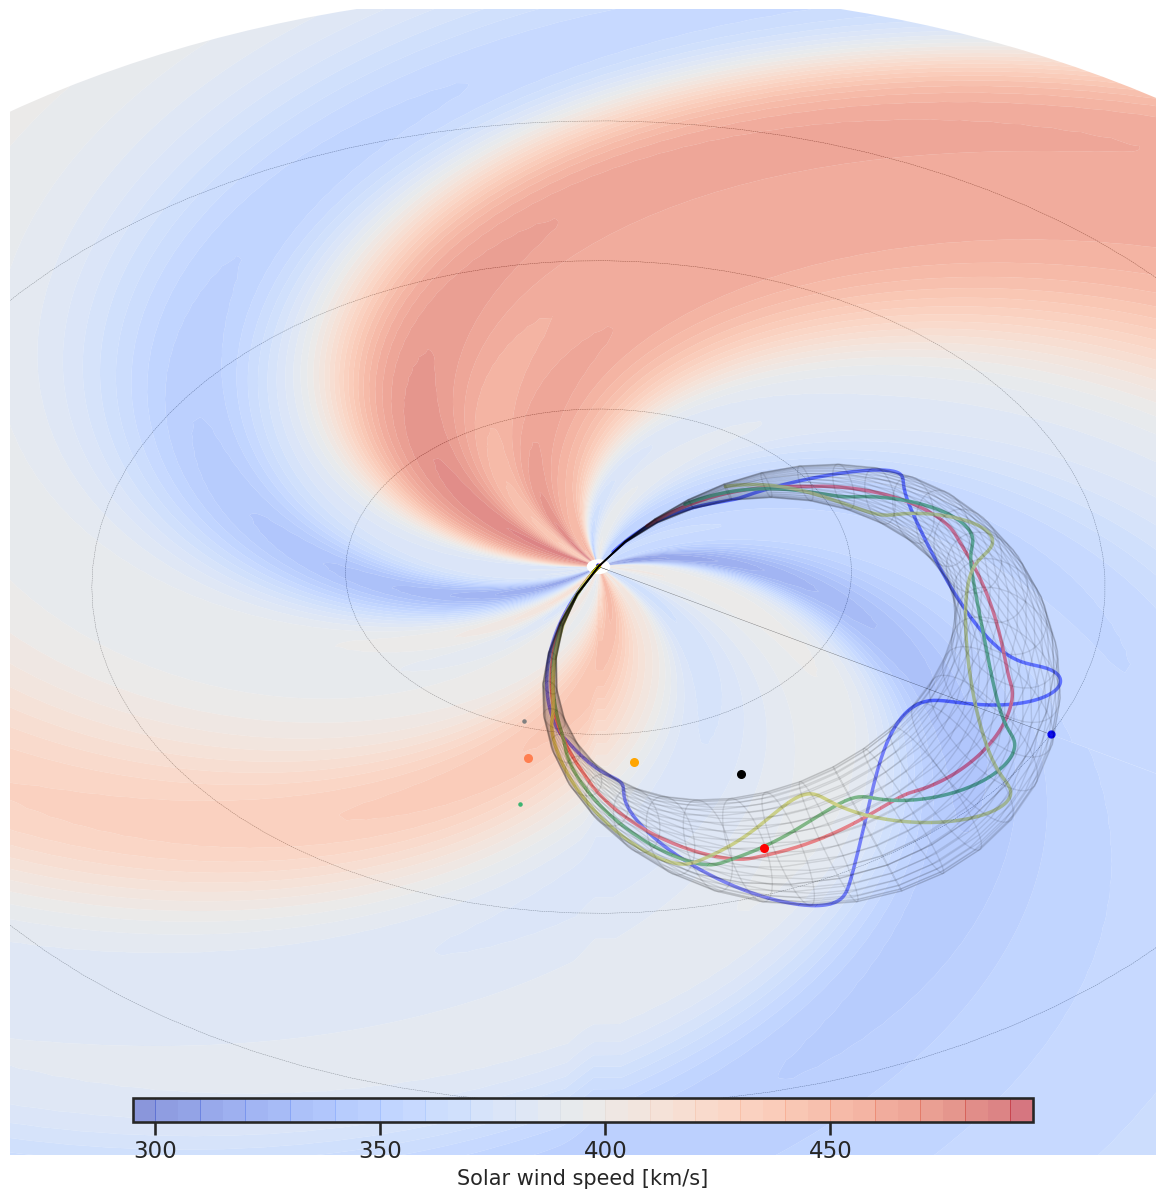

In [237]:
#use either 
#%matplotlib 
#%matplotlib inline
#matplotlib.use('Qt5Agg')
#matplotlib.use('Agg')
#%matplotlib inline

sns.set_context("talk")     
#sns.set_style('whitegrid',{'grid.linestyle': '--'})

sns.set_style("ticks",{'grid.linestyle': '--'})
fsize=15

fig=plt.figure(1,figsize=(15,12),dpi=100)
ax = fig.add_subplot(111, projection='3d')

#plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.8)
#in other planes
plot_configure(ax, view_azim=-60, view_elev=40, view_radius=0.9)
#plot_configure(ax, view_azim=0, view_elev=0, view_radius=0.6)


##plot sun
#define sun here so it does not need to be recalculated every time
scale=695510/149597870.700*1 #Rs in km, AU in km
# sphere with radius Rs in AU
u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:30j]
xsun = np.cos(u)*np.sin(v)*scale
ysun = np.sin(u)*np.sin(v)*scale
zsun = np.cos(v)*scale
#draw Sun
ls = LightSource(azdeg=140, altdeg=40)  
ax.plot_surface(x, y, z, rstride=1, cstride=1, color='yellow',lightsource=ls, linewidth=0, antialiased=True,zorder=5)

#####plot solar wind
plot_bgsw(ax,cbarax1)

########## 3dcore plots
#plot_3dcore(ax, model_obj, tm0, color=c1)
#plot_3dcore_field(ax, model_obj, color=c1, step_size=0.005, lw=1.1, ls="-",q0=np.array([1, .1, np.pi/2]))

plot_3dcore(ax, model_obj, tm1, color='k',alpha=0.1)
plot_3dcore_field(ax, model_obj, color='b', step_size=0.01, lw=2.5, ls="-",q0=np.array([1, .1, np.pi/2]))
plot_3dcore_field(ax, model_obj, color='r', step_size=0.01, lw=2.5, ls="-",q0=np.array([0.2, .3, np.pi/2]))
plot_3dcore_field(ax, model_obj, color='g', step_size=0.01, lw=2.5, ls="-",q0=np.array([0.5, .5, np.pi/2]))
plot_3dcore_field(ax, model_obj, color='y', step_size=0.01, lw=2.5, ls="-",q0=np.array([0.8, .7, np.pi/2]))



#plot_3dcore_field(ax, model_obj, color='g', step_size=0.01, lw=1.1, ls="-")

############# satellite plots
#plot_traj(ax, "Earth", tm1, frame="HEEQ", color=c1)
    
#for i in np.arange(0,len(satpos)):
#    plot_satellite(ax,satpos[i],color='black',alpha=0.9)    
#    plot_satellite(ax,satpos2[i],color='red',alpha=0.9)

plot_satellite(ax,satpos[18],color='blue',alpha=0.9)

plot_traj(ax, "Venus", tm1, frame="HEEQ", color=venus_color,alpha=1.0,s=5,zorder=5)
plot_traj(ax, "Mercury", tm1, frame="HEEQ", color=mercury_color,s=5)
plot_traj(ax, "SOLO",tm1, frame="HEEQ", color=solo_color,s=30)
plot_traj(ax, "PSP", tm1, frame="HEEQ", color=psp_color,s=30)
plot_traj(ax, "STA", tm1, frame="HEEQ", color=sta_color,s=30)
plot_traj(ax, "BEPI", tm1, frame="HEEQ", color=bepi_color,s=30)



##########cosmetics
#approximate Sun Earth line
ax.plot([0,1],[0,0],[0,0],ls='-',color='black',lw=0.3)

plot_circle(ax,0.5)
plot_circle(ax,1.0)
plot_circle(ax,1.5)


limits=0.7
ax.set_xlim(-limits,limits) 
ax.set_ylim(-limits, limits) 
ax.set_zlim(-limits, limits) 
    


plt.tight_layout()

plt.savefig('results/test_thux_3dcore/test.pdf')
plt.savefig('results/test_thux_3dcore/test.png',dpi=200)


current satpos measured is  18
(1., 0., 0.)
input
2020-12-08 06:00:00  /  2020-12-26 06:00:00 HEEQ HEE
data points 432


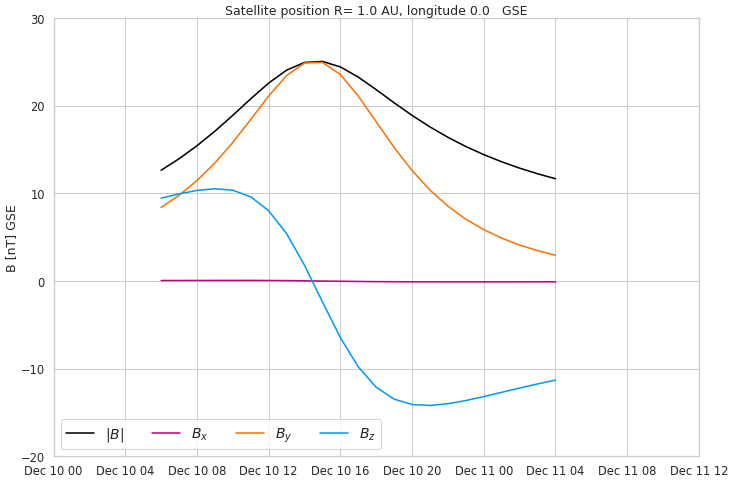

In [6]:
############################### measure magnetic field
print()


#18 is middle
satposindex=18
print('current satpos measured is ', satposindex)
print(satpos[satposindex])


t1, btot1, bxyz1, os1 = measure(model_obj, satpos[satposindex], tm1 - datetime.timedelta(days=3), tm1  + datetime.timedelta(days=15))


################################################
sns.set_context('talk')
sns.set_style('whitegrid')

fig = plt.figure(figsize=(15, 10),dpi=50)

ax1 = fig.add_subplot(111)
ax1.set_title('Satellite position R= 1.0 AU, longitude '+str(satpos.lon[satposindex])+'   GSE')

ax1.plot(t1, btot1, color=cbt, label="$|B|$")
ax1.plot(t1, -bxyz1[:, 0], color=cbx, label="$B_x$")
ax1.plot(t1, -bxyz1[:, 1], color=cby, label="$B_y$")
ax1.plot(t1, bxyz1[:, 2], color=cbz, label="$B_z$")

ax1.legend(loc="lower left", fontsize=20,ncol=4)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %d %H'))
ax1.set_ylabel('B [nT] GSE')
plt.ylim(-20,30)
plt.xlim(datetime.datetime(2020,12,10,0,0,0),datetime.datetime(2020,12,11,12,0,0))


#ax1.plot(noaa.time,noaa.bt,color=cbt)
#ax1.plot(noaa.time,noaa.bx,color=cbx)
#ax1.plot(noaa.time,noaa.by,color=cby)
#ax1.plot(noaa.time,noaa.bz,color=cbz)
plt.tight_layout()

plt.savefig('test_measure_1.png', dpi=50)
plt.savefig('test_measure_1.pdf', dpi=50)